# SCIENCE

Of course, all is well and fun, and we can visualize some cool quantum operations on an 'inmage state', but obviously the main reason for these embeddings is not to make nice pictures, but to use them to encode data for tasks like classification for QML, or we can use image embedding to encode different types of data - linear depth is a pretty nice embedding ratio after-all! 

# QML with QPIXL embedding with classical autoencoder for image compression

So instead of using just a directly image loaded QML, we first pretrain a classical autoencoder and do a transfer learning approach. FOr this toy example we use a pretrained resnet18, but one could imagine refining model parameters to a dataset at the same time as the quantum weights! 

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)
import param_qpixl_qml as pq
from qiskit.circuit import ParameterVector
# Plotting
import matplotlib.pyplot as plt
# SETUP
os.environ["OMP_NUM_THREADS"] = "8"
n_qubits = 11                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 100              # Number of samples for each training step
num_epochs = 30              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# LOAD DATA - INSPIRED BY PENNYLANE DEMO
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "cancer_classifier/Imagenes_Clasificadas_Random_Split/"
image_datasets = {
    x if x == "train" else "test": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "test"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
inputs, classes = next(iter(dataloaders["test"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "test"]
}
model_hybrid = torchvision.models.resnet18(pretrained=True)


Example of part of the dataset

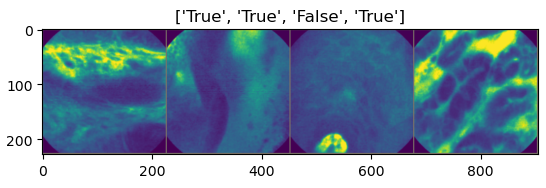

## QNN 
We use a tree tensor network ansatz to try and do the classification

In [ ]:
## QUANTUM NN
def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RZ(weights[1], wires=wires[0])
    qml.RX(weights[2], wires=wires[1])
    qml.RZ(weights[3], wires=wires[1])
    qml.CNOT(wires=wires)
    
dev = qml.device("default.qubit", wires=n_qubits+5)
@qml.qnode(dev, interface="torch")
def quantum_net(input_feat,weights):
    quantum_input = pq.encode_image(input_feat)
    pq.param_qpixl(quantum_input) ## PENNYL:ANE QPIXL
    qml.TTN(wires=range(n_qubits+5),
            n_block_wires=2,
            block=block,
            n_params_block=4,
            template_weights=weights)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [14,15]]
    return tuple(exp_vals)
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost


## Hybrid QNN with classical autoencoder
We use a classical autoencoder to reduce the dimensions in such a way that the image highlights features we want to classify with the QNN, where the embedding is done with QPIXL and the trained weights affect the tensor network tree. Our loss is cross entropy, the preffered method for classification tasks

In [38]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, 32*32)
        self.q_params = nn.Parameter(q_delta * torch.randn((15,4)))
        self.post_net = nn.Linear(2, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, 2)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)


In [39]:
for param in model_hybrid.parameters():
    param.requires_grad = False
model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "test  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "test" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model


In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)


Training started:


/opt/conda/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


### Preliminary results
We were not able to fully train this system in time, but we had some promising preliminary results, reaching an accuracy of 70% on the testing data!
```
Training started:
Phase: train Epoch: 20/30 Loss: 0.6958 Acc: 0.6254      
Phase: test   Epoch: 20/30 Loss: 0.6296 Acc: 0.7099       
``` 


### Visualization

Now we can see how well our model does! 



In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
visualize_model(model_hybrid, num_images=batch_size)
plt.show()
